# Evaluating kNN

Before we get going with the core material, we need a set of functions from our previous efforts.  Let's load those in.  The first command here simply tells Python not to show the previous plots.

In [1]:
%%capture
%run 02_knn.ipynb       

## Evaluating the Classifier: Training/Test splits

If our classifier works, it should be able to correctly classify our *current* patients: it should put the ones who have CKD into the CKD category, and those that do not have it into the CKD-free category.  

But there is a problem here.  The current patients are, collectively, our *training* set.  We already know their statuses for sure, and we don't need predictions for them.  We need predictions for *new* patients who our model has not yet met.  And we don't have an obvious source for those new patients (by definition, they haven't come in yet).

Well why not just assess the accuracy of our classifier on the data we do have, i.e. the training set? Technically, this is because we will end up "over-fitting." This means, essentially, that we end up modeling random error in our data and believing---falsely---we have captured something important and systematic about the relationship between $X$ and $Y$.  This will be a big problem when we try to predict new patients: we will not actually have understood the true systematic relationship between $X$ and $Y$ and will make mistakes for our incoming instances.   

You can get some intuition for this problem by thinking about the original nearest neighbor classifier we used.  We said that we could just look for the single current patient closest to a new patient (in terms of attributes), and then their status becomes our prediction for the new patient.  What happens if we apply that simple rule to our *current* data. Well, every single instance is its own nearest neighbor.  That is, each instance is zero distance from itself, so our prediction for that observation is just whatever we currently know its status to be.  But if this is true, our model is perfectly accurate, even though it has not predicted anything we didn't already know and hasn't used any systematic information about the relationship between $X$ and $Y$ at all.

In general, we cannot use the training data to *test* our classifier.  So we need to find a way to mimic the idea of "new" data which we are trying to predict. 

## Generating A Test Set
Our plan is make these "new" patients from our current data.  We will do this by splitting our data into two parts: one set where we fit the same model as above (the $kNN$) and the other set which we will use as the source of "new" patients.  Importantly, though our model will not yet have seen these "new" patients, we will know their correct outcome class.  And we will know this, because we know it for all *our* data.

More formally, we will proceed as follows:

1. Generate a *random sample* from our original data to form our **training set**. Here, we will sample half the observations, without replacement. Our classifier will use this set to *learn* the relationship between $X$ and $Y$.
2. Generate a *random sample*  from our original data to form our **test set**. This will be the other half of the observations, and we will see how well our classifier does. That is, the test set assesses the *performance* of our model.
3. Use this test set to make inferences about the **rest of the population** (hopefully our test set is similar to them)---i.e. our "new" patients

A couple of notes about this process are in order. First, we sample *without replacement* because we want to make sure we don't have the same observations in the training and test set.  This could lead to the same sorts of problems (like over-fitting) that we mentioned with not having a test set at all.  Second, the 50:50 split is mostly for demonstration. In real problems, analysts use all sorts of splits, with 80:20 (train: test) being a popular one.

### Training/Test Split: An Example
Let's return to our 'tough' problem above.  We had a data set that looked like this:

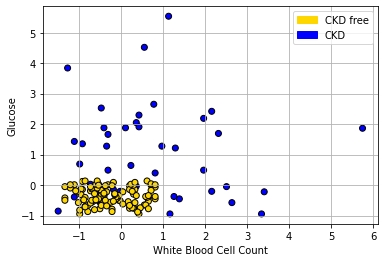

In [2]:
plt.scatter(std_status['White Blood Cell Count'], 
            std_status['Glucose'], 
            color= std_status['status'].map(colors), edgecolor='k')

plt.legend(handles=[gold_patch, blue_patch])
plt.xlabel('White Blood Cell Count')
plt.ylabel("Glucose")

plt.grid()
plt.show()

We can make a training and test set as follows: 

In [3]:
shuffled_ckd = std_status.sample(frac=1, replace=False, random_state= 3)
training = shuffled_ckd.iloc[np.arange(79),]
testing = shuffled_ckd.iloc[np.arange(79, 158),]

The first line tells Python to randomly sample the entire data set. This is equivalent to shuffling it randomly.  The `random_state=3` just tells Python to do exactly the same random draw for everyone using the code.  Then the `training` set is formed by taking the first 79 observations of the shuffled data set; the `testing` set is formed by taking what is left (there are 158 observations total).  This operation is obviously equivalent to just randomly creating a training and test set from the data. 

We can plot our training data (on a slightly restricted access, just for presentation):

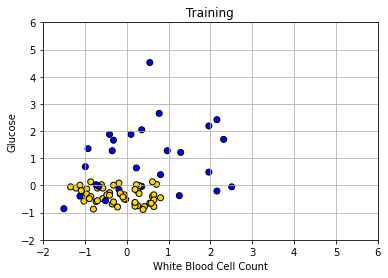

In [4]:
plt.scatter(training['White Blood Cell Count'], 
            training['Glucose'], color= training['status'].map(colors), edgecolor='k')
plt.xlabel("White Blood Cell Count")
plt.ylabel("Glucose")
plt.title("Training")
plt.grid()
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.show()

Obviously, there is only half as much data as before.  Let's now make our decision boundary.  In a real problem, we would not *have* to do this part first---we could just go ahead and try to predict the test set points---but the visualization is instructive. As above, we start with a data point for every part of the space:

In [5]:
x_array = np.array([])
y_array = np.array([])
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
grid_data2 = {
    'Glucose': x_array,
    'White Blood Cell Count': y_array
}
test_grid2 = pd.DataFrame(grid_data2)

Now we classify all these points, dropping `Hemoglobin` from the data first (because we don't need it).

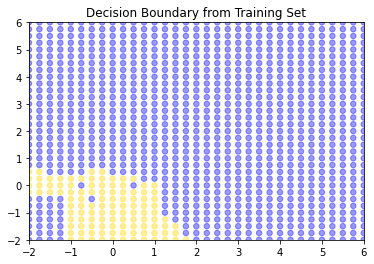

In [6]:
c2 = classify_grid(training.drop(['Hemoglobin', 'status'], axis=1), test_grid2, 1)

test_grid2["Class"] = c2
test_grid2.loc[test_grid2['Class']== 1,'status'] = 'CKD'
test_grid2.loc[test_grid2['Class']== 0,'status'] = 'CKD free'

plt.scatter(test_grid2['White Blood Cell Count'], 
            test_grid2['Glucose'], color= test_grid2['status'].map(colors), 
            alpha=0.4, s=30)

plt.title("Decision Boundary from Training Set")

plt.xlim(-2, 6)
plt.ylim(-2, 6);

So, this is the decision boundary that we learned from the *training* set.  It is what our model predicts for any given point in the space. Let's draw this again, but put our *test* set onto the plot: remember, we *know* the actual outcomes for those points, but they weren't not involved in fitting the model.

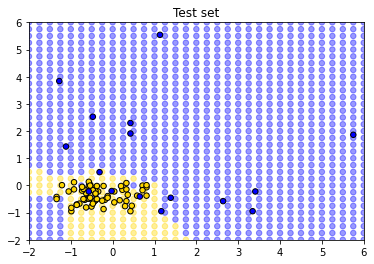

In [7]:
plt.scatter(test_grid2['White Blood Cell Count'], test_grid2['Glucose'], 
            color= test_grid2['status'].map(colors), 
            alpha=0.4, s=30)

plt.scatter(testing['White Blood Cell Count'], 
            testing['Glucose'], color= testing['status'].map(colors), 
            s=30, ec="black")
plt.title("Test set")

plt.xlim(-2, 6)
plt.ylim(-2, 6);

How did we do?  Well it looks like the blue points are mostly in the blue area, and the yellow points are mostly in the yellow area.  But there are a few mistakes: a few *mis-classifications* have occurred, in the sense that our model predicts that some points in the lower left should be yellow (CKD free) but those observations (from the test set) actually were blue (had CKD).

These examples make the basic intuition of $kNN$ classification obvious.  But, of course, it's time consuming to plot the decision boundary every time -- we just want a prediction. Moreover, in a real problem we would usually have more than two dimensions (two attributes).  The good news is that  $kNN$ can deal with these requirements without issue.